In [1]:
from pathlib import Path

import pandas as pd
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import seaborn as sns

In [2]:
dates_to_visualize = [
                                                                                            "2018-09", "2018-10", "2018-11", "2018-12",
    "2019-01", "2019-02", "2019-03", "2019-04", "2019-05", "2019-06", "2019-07", "2019-08", "2019-09", "2019-10", "2019-11", "2019-12",
    "2020-01", "2020-02", "2020-03", "2020-04", "2020-05", "2020-06", "2020-07", "2020-08", "2020-09", "2020-10", "2020-11", "2020-12",
    "2021-01", "2021-02", "2021-03", "2021-04", "2021-05", "2021-06", "2021-07", "2021-08", "2021-09", "2021-10", "2021-11", "2021-12",
    "2022-01", "2022-02", "2022-03", "2022-04", "2022-05", "2022-06", "2022-07", "2022-08", "2022-09", "2022-10", "2022-11", "2022-12",
    "2023-01", "2023-02", "2023-03", "2023-04", "2023-05", "2023-06", "2023-07", "2023-08", "2023-09", "2023-10", "2023-11", "2023-12",
    "2024-01", "2024-02", "2024-03", "2024-04", 
]

In [3]:
available_data_files = list(Path("../data/httparchive_metrics/nel_domain_resource_monitoring_stats").glob("*.parquet"))

used_data_files = list(filter(lambda file: file.stem in dates_to_visualize, available_data_files))
used_data_files

[WindowsPath('../data/httparchive_metrics/nel_domain_resource_monitoring_stats/2018-09.parquet'),
 WindowsPath('../data/httparchive_metrics/nel_domain_resource_monitoring_stats/2018-10.parquet'),
 WindowsPath('../data/httparchive_metrics/nel_domain_resource_monitoring_stats/2018-11.parquet'),
 WindowsPath('../data/httparchive_metrics/nel_domain_resource_monitoring_stats/2018-12.parquet'),
 WindowsPath('../data/httparchive_metrics/nel_domain_resource_monitoring_stats/2019-02.parquet'),
 WindowsPath('../data/httparchive_metrics/nel_domain_resource_monitoring_stats/2019-03.parquet'),
 WindowsPath('../data/httparchive_metrics/nel_domain_resource_monitoring_stats/2019-04.parquet'),
 WindowsPath('../data/httparchive_metrics/nel_domain_resource_monitoring_stats/2019-05.parquet'),
 WindowsPath('../data/httparchive_metrics/nel_domain_resource_monitoring_stats/2019-06.parquet'),
 WindowsPath('../data/httparchive_metrics/nel_domain_resource_monitoring_stats/2019-07.parquet'),
 WindowsPath('../dat

### Aggregate result to visualize

In [4]:
from results.result_utils import date_to_text_format, concat_data_from_files

result = concat_data_from_files(used_data_files)

result['date_formatted'] = result['date'].map(date_to_text_format)

result

,date,url_domain,url_domain_hosted_resources,url_domain_hosted_resources_with_nel,url_domain_monitored_resources_ratio,date_formatted
0,2018-09,m2.cn.bing.com,159,1,0.630000,Sep 2018
1,2018-09,www4.bing.com,179,1,0.560000,Sep 2018
0,2018-10,classifieds.seloc.org,124,68,54.840000,Oct 2018
1,2018-10,cpqa.catchpoint.com,1,1,100.000000,Oct 2018
2,2018-10,forums.seloc.org,10,1,10.000000,Oct 2018
...,...,...,...,...,...,...
2608537,2024-04,zzztube.com,12,12,100.000000,Apr 2024
2608538,2024-04,zzztube.tv,10,10,100.000000,Apr 2024
2608539,2024-04,zzzz.bg,4,4,100.000000,Apr 2024
2608540,2024-04,zzzzap.nl,193,192,99.480003,Apr 2024


### NEL Domain monitored resources ratio distribution

In [5]:
from results.result_utils import get_first_or_0

distribution_result = pd.DataFrame({}, index=[
    '(0%-10%>',
    '(10%-25%>',
    '(25%-50%>',
    '(50%-75%>',
    '(75%-100%)',
    '<100%>',
])

for month in dates_to_visualize:
    current_month_data = result[result['date'] == month].copy()
    
    month_data_col = []

    # month_result['(0%-10%>']    
    next_val = current_month_data[(current_month_data['url_domain_monitored_resources_ratio'] > 0.0) & (current_month_data['url_domain_monitored_resources_ratio'] <= 10.0)].count()
    month_data_col.append(get_first_or_0(next_val))

    # month_result['(10%-25%>']    
    next_val = current_month_data[(current_month_data['url_domain_monitored_resources_ratio'] > 10.0) & (current_month_data['url_domain_monitored_resources_ratio'] <= 25.0)].count()
    month_data_col.append(get_first_or_0(next_val))

    # month_result['(25%-50%>']    
    next_val = current_month_data[(current_month_data['url_domain_monitored_resources_ratio'] > 25.0) & (current_month_data['url_domain_monitored_resources_ratio'] <= 50.0)].count()
    month_data_col.append(get_first_or_0(next_val))

    # month_result['(50%-75%>']    
    next_val = current_month_data[(current_month_data['url_domain_monitored_resources_ratio'] > 50.0) & (current_month_data['url_domain_monitored_resources_ratio'] <= 75.0)].count()
    month_data_col.append(get_first_or_0(next_val))

    # month_result['(75%-100%)']    
    next_val = current_month_data[(current_month_data['url_domain_monitored_resources_ratio'] > 75.0) & (current_month_data['url_domain_monitored_resources_ratio'] < 100.0)].count()
    month_data_col.append(get_first_or_0(next_val))
    
    # month_result['<100%>']
    next_val = current_month_data[current_month_data['url_domain_monitored_resources_ratio'] == 100.0].count()
    month_data_col.append(get_first_or_0(next_val))
    
    
    distribution_result[date_to_text_format(month)] = month_data_col
    
distribution_result

,Sep 2018,Oct 2018,Nov 2018,Dec 2018,Jan 2019,Feb 2019,Mar 2019,Apr 2019,May 2019,Jun 2019,...,Jul 2023,Aug 2023,Sep 2023,Oct 2023,Nov 2023,Dec 2023,Jan 2024,Feb 2024,Mar 2024,Apr 2024
(0%-10%>,2,5,10,18,0,29,26,134,186,141,...,27601,27649,33057,31877,30786,31713,30834,31838,31648,32069
(10%-25%>,0,2,5,7,0,7,15,197,127,215,...,2604,2817,3288,4979,3637,4271,3008,3681,3738,3133
(25%-50%>,0,1,2,5,0,8,12,3593,2371,3520,...,5767,6369,7063,17970,8462,6688,7289,8087,8727,6278
(50%-75%>,0,1,3,3,0,25,29,26203,19313,26300,...,7065,7409,7719,23815,8910,8093,8578,9517,9388,8447
(75%-100%),0,0,6,9,0,29,38,8478,9771,9362,...,117439,123035,126269,141631,139939,140336,139620,145738,142117,147855
<100%>,0,1,161,333,0,271,262,35983,49118,39675,...,2266022,2305620,2356238,2369138,2461746,2326968,2269730,2345241,2380631,2410723


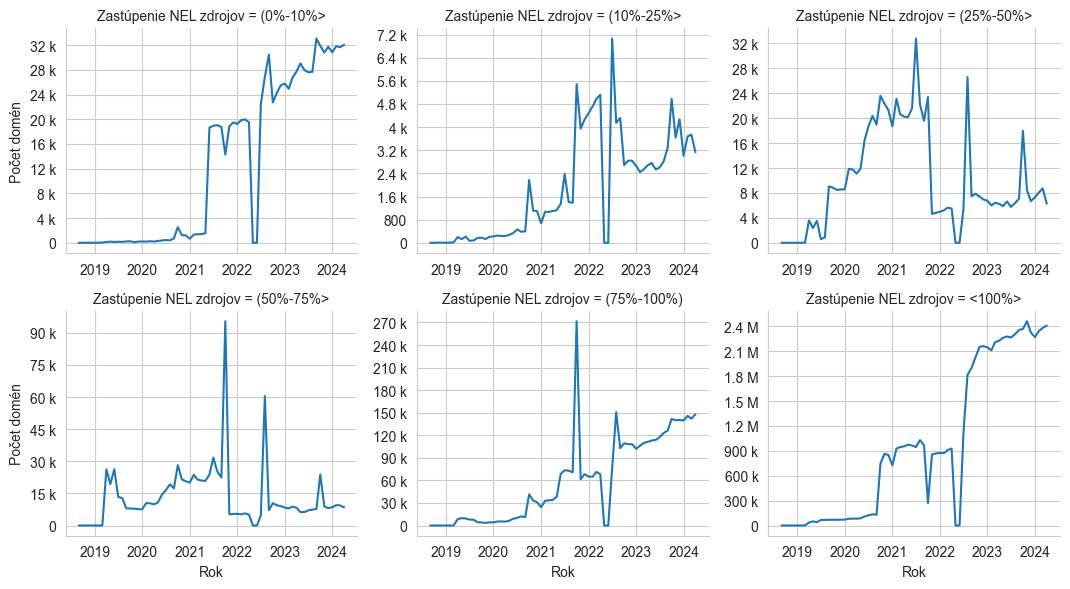

In [15]:
to_plot = distribution_result.stack()
to_plot = to_plot.reset_index()
to_plot.rename(columns={'level_0': 'Zastúpenie NEL zdrojov', 'level_1': 'date', 0: 'domain_count'}, inplace=True)

to_plot['date_fmt'] = to_plot['date'].map(lambda date: pd.to_datetime(date))

sns.set_style('whitegrid')

g = sns.relplot(to_plot, kind='line', x='date_fmt', y='domain_count', 
                col='Zastúpenie NEL zdrojov', col_wrap=3, 
                height=3, aspect=1.2, 
                facet_kws={'sharey': False, 'sharex': False}
                )

for idx, ax in enumerate(g.axes):
    ax.xaxis.remove_overlapping_locs = False
    years = mdates.YearLocator()
    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

    ax.xaxis.set_minor_locator(ticker.NullLocator())
    

    ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    ax.yaxis.set_major_formatter(ticker.EngFormatter())
    
    ax.tick_params(axis='x', which="minor", rotation=90, labelsize=9)

g.set_xlabels("Rok")
g.set_ylabels("Počet domén")

# g.figure.suptitle("Zastúpenie NEL zdrojov v porovnaní k celkovnému počtu zdrojov počas skúmaného obdobia")
g.tight_layout()

g.savefig("graphs/httparchive_nel_monitored_resources_percentage_dist.pdf")